In [3]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor) #has the rownames_to_column function

In [4]:
#Load in the chronos data
setwd("../data")
ccle.chronos = read.table("22q1_crispr_gene_effect.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

#Get a vector of samples in the chronos data
chronos.samples = ccle.chronos %>% pull(sample)

In [5]:
#Load in the gene block matrix to save a bunch of compute time if I ever need to re-make the figure
setwd("../data")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
#Also filter it so that it only includes samples that have chronos scores
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample)) %>%
filter(sample %in% chronos.samples)

In [6]:
#Calculate the number of cell lines for each gene
num.afr = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "0")))
num.amr = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "1")))
num.eas = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "2")))
num.eur = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "3")))
num.sas = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "4")))

In [7]:
#Bind them all together into a single data frame 
lines.with.ancestry.per.gene = rbind(num.afr, num.amr, num.eas, num.eur, num.sas) %>% 
t() %>%
data.frame() %>%
rownames_to_column("gene") %>%
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6)

#Calculate the average for each ancestry group
afr.average = lines.with.ancestry.per.gene %>% pull(afr) %>% mean()
amr.average = lines.with.ancestry.per.gene %>% pull(amr) %>% mean()
eas.average = lines.with.ancestry.per.gene %>% pull(eas) %>% mean()
eur.average = lines.with.ancestry.per.gene %>% pull(eur) %>% mean()
sas.average = lines.with.ancestry.per.gene %>% pull(sas) %>% mean()

#Calculate the total number of samples
formatted.gene.block.matrix %>% nrow()

[1] 611

In [8]:
#Calculate the mean SD across all chronos.scores
chronos.mean.sd = ccle.chronos %>%
select(-sample) %>%
apply(2, sd) %>%
mean(na.rm = TRUE)

In [9]:
#Load in the sample annotation data
setwd("../data")
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

In [10]:
#Construct a vector of mean differences that we are interested in simulating p-values for
mean.difference.vector = seq(from = 0.01, to = 1, by = 0.01)

In [11]:
#Compute simulated p-values for all of the AFR samples
#Who cares about DRY? Copy/paste is easier.
afr.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 26
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        afr.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.afr.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(afr.simulated.values, non.afr.simulated.values)
        sample.code.vector = c(rep(0, length(afr.simulated.values)), rep(1, length(non.afr.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            afr.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [12]:
#Compute simulated p-values for all of the AMR samples
#Who cares about DRY? Copy/paste is easier.
amr.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 6
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        amr.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.amr.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(amr.simulated.values, non.amr.simulated.values)
        sample.code.vector = c(rep(0, length(amr.simulated.values)), rep(1, length(non.amr.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            amr.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [13]:
#Compute simulated p-values for all of the EAS samples
#Who cares about DRY? Copy/paste is easier.
eas.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 203
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        eas.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.eas.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(eas.simulated.values, non.eas.simulated.values)
        sample.code.vector = c(rep(0, length(eas.simulated.values)), rep(1, length(non.eas.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            eas.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [14]:
#Compute simulated p-values for all of the EUR samples
#Who cares about DRY? Copy/paste is easier.
eur.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 373
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        eur.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.eur.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(eur.simulated.values, non.eur.simulated.values)
        sample.code.vector = c(rep(0, length(eur.simulated.values)), rep(1, length(non.eur.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            eur.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [15]:
#Compute simulated p-values for all of the SAS samples
#Who cares about DRY? Copy/paste is easier.
sas.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 4
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        sas.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.sas.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(sas.simulated.values, non.sas.simulated.values)
        sample.code.vector = c(rep(0, length(sas.simulated.values)), rep(1, length(non.sas.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            sas.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [16]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("../data")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

In [17]:
#Get the thresholds for the power calculation from the real data
#Kind of reverse order from how things should be done but whatever
afr.threshold = lineage.corrected.pvals %>% 
select(afr.lm.pval.vector, afr_fdr) %>% 
filter(afr_fdr < 0.05) %>% 
arrange(desc(afr_fdr)) %>%
pull(afr.lm.pval.vector) %>%
.[1]

amr.threshold = lineage.corrected.pvals %>% 
select(amr.lm.pval.vector, amr_fdr) %>% 
filter(amr_fdr < 0.05) %>% 
arrange(desc(amr_fdr)) %>%
pull(amr.lm.pval.vector) %>%
.[1]

eas.threshold = lineage.corrected.pvals %>% 
select(eas.lm.pval.vector, eas_fdr) %>% 
filter(eas_fdr < 0.05) %>% 
arrange(desc(eas_fdr)) %>%
pull(eas.lm.pval.vector) %>%
.[1]

eur.threshold = lineage.corrected.pvals %>% 
select(eur.lm.pval.vector, eur_fdr) %>% 
filter(eur_fdr < 0.05) %>% 
arrange(desc(eur_fdr)) %>%
pull(eur.lm.pval.vector) %>%
.[1]

sas.threshold = lineage.corrected.pvals %>% 
select(sas.lm.pval.vector, sas_fdr) %>% 
filter(sas_fdr < 0.05) %>% 
arrange(desc(sas_fdr)) %>%
pull(sas.lm.pval.vector) %>%
.[1]

In [18]:
#For all of the simulated data, calculate the number of values greater than the threshold
afr.statistical.power = afr.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < afr.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

amr.statistical.power = amr.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < amr.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

eas.statistical.power = eas.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < eas.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

eur.statistical.power = eur.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < eur.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

sas.statistical.power = sas.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < sas.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

In [19]:
#Write the data frame
setwd("../output")
statistical.power.df = cbind(mean.difference.vector, afr.statistical.power, amr.statistical.power, eas.statistical.power, eur.statistical.power, sas.statistical.power) %>%
data.frame() %>%
rename("mean_difference" = 1, "afr_pwr" = 2, "amr_pwr" = 3, "eas_pwr" = 4, "eur_pwr" = 5, "sas_pwr" = 6)

write.table(statistical.power.df, "figure_1c_data.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

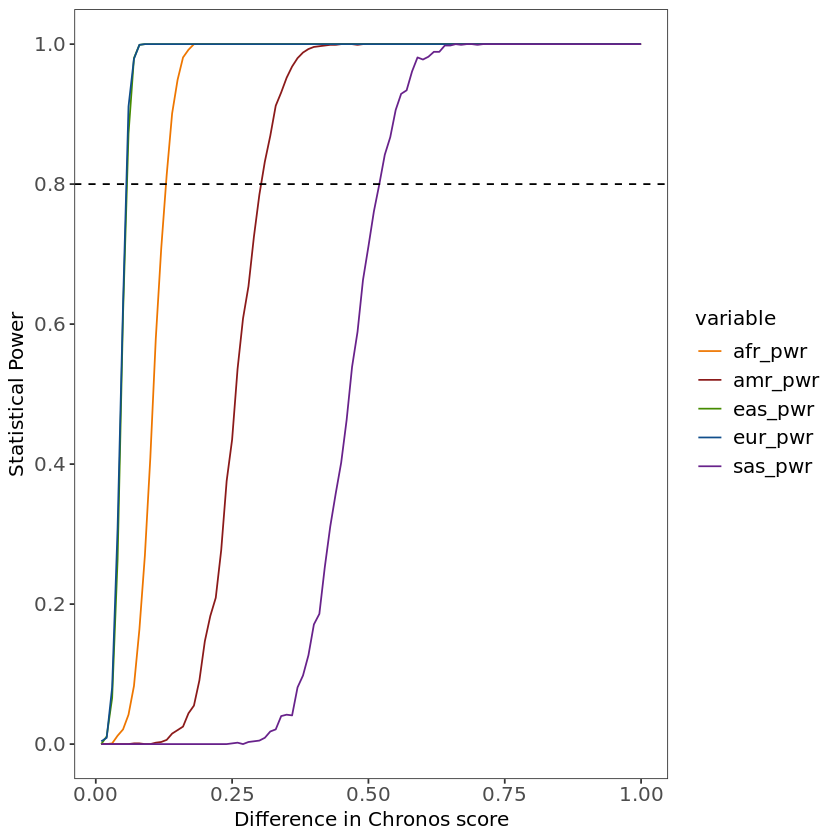

In [20]:
#Plot the plot of statistical power
statistical.power.df %>%
melt(id = "mean_difference") %>%
mutate(value = value/1000) %>%
ggplot(aes(x = mean_difference, y = value, color = variable)) +
geom_line() +

geom_hline(yintercept = 0.8 , linetype = 2) +

theme_bw() +

scale_color_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Statistical Power") +
xlab("Difference in Chronos score") +

scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1))

#Export it to the google bucket
setwd("../output")
ggsave("figure_1c.pdf", width = 4, height = 3)